<a href="https://colab.research.google.com/github/nohasamir89/noha_project/blob/main/use_tm_vec_to_predict_tm_scores_for_pairs_of_sequences_noha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library.
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to predict TM-Scores for pairs of protein sequences.


<h3>Predicting TM-Scores using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, deepblast, and the huggingface transformers library**

In [1]:
!pip install tm-vec

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 33.5 MB/s eta 0:00:00
  Created wheel for tm-vec: filename=tm_vec-1.0.3-py3-none-any.whl size=15421 sha256=26a21735dbf29480654d2954bd340aa23b4376cbf91001933a1b09d2a79b36ba
  Stored in directory: /root/.cache/pip/wheels/8f/4a/9c/e3331a09e67f571bfddf2e88b75d947930a967a1f7f488993b
  Created wheel for deepblast: filename=deepblast-1.0.2-py3-none-any.whl size=61893 sha256=eaf9db180e91b9f2719453367d81a55bb4196b7415baaba60375580c26063e17
  Stored in directory: /root/.cache/pip/wheels/ff/d8/b6/30425e59491094eb2d1b1b72409ddaabc7977d066f3ab822fa
Successfully built tm-vec deepblast


In [2]:
!pip install deepblast

In [3]:
!pip install -q SentencePiece transformers

<b>2. Load the relevant libraries<b>

In [6]:
%pip install faiss-cpu
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm


import matplotlib.pyplot as plt
import seaborn as sns


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 26.9 MB/s eta 0:00:00


<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [7]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [8]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

In [9]:
gc.collect()

77

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
print(device)

cpu


In [12]:
model = model.to(device)
model = model.eval()

<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt

--2022-12-21 16:37:24--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt [following]
--2022-12-21 16:37:24--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 207922348 (198M) [application/octet-stream]
Saving to: ‘tm_vec_cath_model.ckpt’

tm_vec_cath_model.c 100%[===================>] 198.29M  25.0MB/s    in 7.7s    

2022-12-21 16:37:32 (25.8 MB/s) - ‘tm_vec_cath_model.ckpt’ saved [207922348/207922348]



In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json

--2022-12-21 16:37:32--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json [following]
--2022-12-21 16:37:33--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 181 [application/json]
Saving to: ‘tm_vec_cath_model_params.json’

tm_vec_cath_model_p 100%[===================>]     181  --.-KB/s    in 0s      

2022-12-21 16:37:33 (57.5 MB/s) - ‘tm_vec_cath_model_params.json’ saved [181/181]



<b> 5. Load the trained TM-Vec model<b>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
#TM-Vec model paths
tm_vec_model_cpnt = "/content/drive/MyDrive/tm_vec_cath_model.ckpt"
tm_vec_model_config = "/content/drive/MyDrive/tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.8 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/tm_vec_cath_model.ckpt`


<b> 6. Load or paste some pairs of protein sequences that you would like to predict TM-Scores for<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv

--2022-12-21 16:41:25--  https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv [following]
--2022-12-21 16:41:25--  https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 65007 (63K) [application/octet-stream]
Saving to: ‘malidup_sequences_and_tm_scores.csv’

malidup_sequences_a 100%[===================>]  63.48K  --.-KB/s    in 0.08s   

2022-12-21 16:41:25 (806 KB/s) - ‘malidup_sequences_and_tm_scores.csv’ saved [65007/65007]



In [ ]:
sequences = pd.read_csv('malidup_sequences_and_tm_scores.csv')

In [ ]:
#Sample some sequences (for running on CPU which is much slower)
sequence_df = sequences.sample(25).reset_index(drop=True)

<b> 7. Predict TM-Scores using TM-Vec <b>



In [ ]:
#This will be much faster (orders of magnitude) on a GPU than a CPU
tm_score_predictions = []
for i in range(sequence_df.shape[0]):
    sequence_1 = sequence_df.loc[i, 'Sequence 1']
    sequence_2 = sequence_df.loc[i, 'Sequence 2']

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)

    #Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    #Embed sequence 1 and 2 using TM-Vec, applied to the ProtTrans features
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

    #Predict the TM-score for sequence 1 and 2, using the TM-Vec embeddings
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))

    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
      print(i, " TM-Scores predicted")

0  TM-Scores predicted
10  TM-Scores predicted
20  TM-Scores predicted


<b>8. Visualize TM-score predictions versus the ground truth TM-scores<b>

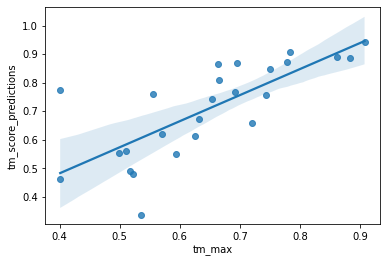

In [ ]:
sequence_df['tm_score_predictions'] = np.array(tm_score_predictions)
sns.regplot(data=sequence_df, x="tm_max", y="tm_score_predictions")

In [15]:


# Load your CSV file from Google Drive
file_path = '/content/drive/MyDrive/MED4_full.csv'
pairs_df = pd.read_csv(file_path, header=None, names=['Sequence 1', 'Sequence 2'])

# Convert comma-separated sequences into separate columns if needed
if pairs_df.shape[1] == 1:
    pairs_df[['Sequence 1', 'Sequence 2']] = pairs_df[0].str.split(',', expand=True)
    pairs_df = pairs_df.drop(0, axis=1)

# Sample 500,000 sequences randomly
sampled_pairs_df = pairs_df.sample(n=10000, random_state=42)

print(f"Original number of sequence pairs: {len(pairs_df)}")
print(f"Number of sampled sequence pairs: {len(sampled_pairs_df)}")
print("\nFirst few sampled pairs:")
print(sampled_pairs_df.head())

# Now predict TM-Scores
tm_score_predictions = []
for i in range(sampled_pairs_df.shape[0]):
    sequence_1 = sampled_pairs_df.iloc[i]['Sequence 1']
    sequence_2 = sampled_pairs_df.iloc[i]['Sequence 2']

    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)

    # Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    # Embed sequence 1 and 2 using TM-Vec
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)

    # Predict the TM-score
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))

    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
        print(f"Progress: {i}/{len(sampled_pairs_df)} TM-Scores predicted")

# Add predictions to dataframe
sampled_pairs_df['TM_Score_Prediction'] = np.array(tm_score_predictions)

# Save results back to Google Drive
output_path = '/content/drive/MyDrive/tm_score_predictions_MED4_10k_sample_results.csv'
sampled_pairs_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

# Create visualizations
plt.figure(figsize=(12, 6))
plt.hist(tm_score_predictions, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Predicted TM-Scores for MED4 (500k sample)')
plt.xlabel('Predicted TM-Score')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Print summary statistics
print("\nSummary Statistics of Predictions:")
print(pd.Series(tm_score_predictions).describe())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original number of sequence pairs: 1919820
Number of sampled sequence pairs: 500000

First few sampled pairs:
                                                Sequence 1  \
1353960  LTKSIVIFNELEKCLDLLNVFKDKSIFLTECLLILPSKEKTTPDQQ...   
111760         MKPKEETEKAIDEIVKIIQKFQYNYELSEKYKREILDQDKIYD   
946343   MAKLHDMRLKLLIQQEHERISKSQPNDLDLSIVQARCLCWLSLLAE...   
179468     MSNSQAPMQAVEVRVYPIFTIRWLAVHALAIPSVFFLGAIAAMQFLR   
1905961  MWKINFKLFLKLLIFFPLIFYFGKRSYLAYDEGFYALQARWILEKG...   

                                                Sequence 2  
1353960  MQMHIIKKEDLKNHIFIDHTLIINEIERSIKSYNWDFILSSLPSGS...  
111760   MNIKYLTVITILFLCCIFGFEETSYSLNKGNQNDISELKILKYLPK...  
946343   MTLNLEAKKILLRKIPHGLFICGVKDDETNEVNGFTASWVTQGSFT...  
179468   MKPQLTLQTPLELPHQEISNYLNQLWISEDEESVGANTFTLMVWQP...  
1905961  MKEIGWPTIDSKHLVVYSKQMLDLENEIFSQGMPQEALMEKVGIQL...  
Progress: 0/500000 TM-

KeyboardInterrupt: 